In [1]:
import sys
sys.path.append('../Modules')
import numpy as np
import pandas as pd
import galsim

import Image_Fits_Stats
#import Visual_analysis

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
import pywt
from scipy.stats import norm
import math

In [2]:
#Size of region to extract the noise from
noise_border_size=8

#Galsim arguments
target_size=64
galaxy_type='real'
psf_type='real'

cat = galsim.COSMOSCatalog(sample='23.5')
#Pixel scale in arcsec (the same for all the galaxies)
_,_,_,pixel_scale,_=cat.getRealParams(0)

def Convolve_with_PSF(gal):
    #Get the PSF object
    psf = gal.original_psf
    #Perform convolution with PSF
    return galsim.Convolve(gal, psf)

def get_galaxy(index):
    #Making galaxy
    gal=cat.makeGalaxy(index,gal_type=galaxy_type)
    
    #Get the PSF object
    psf = gal.original_psf
    #Perform convolution with PSF to get the original HST image
    gal=galsim.Convolve(gal, psf)
    
    #Get noise
    _,_,_,_,COSMOS_noise_variance=cat.getRealParams(index)
    COSMOS_noise=np.sqrt(COSMOS_noise_variance)
    return gal,COSMOS_noise


'''
skimage.restoration.estimate_sigma
[1] D. L. Donoho and I. M. Johnstone. "Ideal spatial adaptation 
by wavelet shrinkage." Biometrika 81.3 (1994): 425-455.
       :DOI:`10.1093/biomet/81.3.425`
'''
def estimate_sigma(image,noise_border_size):
    
    #Extract 4 diagonal border regions to estimate backgroud noise
    Borders=np.array([image[:noise_border_size,:noise_border_size],
                      image[:noise_border_size,-noise_border_size:],
                      image[-noise_border_size:,:noise_border_size],
                      image[-noise_border_size:,-noise_border_size:]])
    Borders=Borders.flatten()
    
    coeffs = pywt.dwtn(Borders, wavelet='db2')
    detail_coeffs = coeffs['d' * Borders.ndim]

    # Consider regions with detail coefficients exactly zero to be masked out
    detail_coeffs = detail_coeffs[np.nonzero(detail_coeffs)]

    # 75th quantile of the underlying, symmetric noise distribution
    denom = norm.ppf(0.75)
    return np.median(np.abs(detail_coeffs)) / denom






        
def get_rotated_gal(index):
    gal,noise=get_galaxy(index)

    #Original image
    original_image=gal.drawImage(use_true_center=True, method='auto').array
    #Rotation
    Sersic_fit,_=Image_Fits_Stats.fit_image(original_image)
    q,x0,y0,phi=Sersic_fit[-4:]
    # It turns anticlockwise, therefore we need to pass -angle
    rot_phi=galsim.Angle(-phi*radians)
    rotated_image=gal.rotate(rot_phi).drawImage(use_true_center=True, method='auto').array
    estimated_noise_rot=estimate_sigma(rotated_image,20)
    return rotated_image,estimated_noise_rot,x0,y0,q

def compare_errors(index):
    
    rotated_image,estimated_noise_rot,x0,y0,q=get_rotated_gal(index)
    
    
    Radial_profile=Image_Fits_Stats.Radial_profile(rotated_image,q,x0,y0,0)

    #Getting border of galaxy from radial profile
    Radial_profile=Radial_profile-Radial_profile[-1]
    Radial_profile/=np.nanmax(Radial_profile)
    R_cut=np.where((Radial_profile<0.01))[0][0]
    
    Poisson_errors=np.sqrt(np.abs(rotated_image[round(x0)]/2028))
    Gaussian_errors=np.full(rotated_image.shape[1],estimated_noise_rot)

    plt.figure(figsize=(15,10))
    plt.title('Chi squared error 'r'$\sigma^2$')
    plt.plot(Poisson_errors**2,label=r'Poisson $\sigma^2$')
    plt.hlines(Gaussian_errors**2,0,rotated_image.shape[1],label=r'Gaussian $\sigma^2$',color='r')
    plt.vlines(y0+R_cut,0,estimated_noise_rot**2,color='k',label='R_cut')
    plt.vlines(y0-R_cut,0,estimated_noise_rot**2,color='k',label='R_cut')
    plt.legend()
    plt.show()
    
    return rotated_image,R_cut,np.abs(np.where(Poisson_errors<Gaussian_errors)[0]-y0).min(),x0,y0

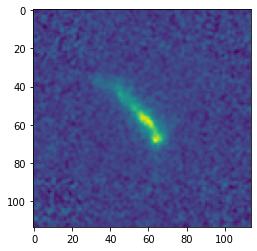

In [3]:
index=16
gal,noise=get_galaxy(index)
original_image=gal.drawImage(use_true_center=True, method='auto').array
plt.imshow(original_image)

# Correlation between COSMOS provided data and estimated one

Compare results on thousand randomly chosen galaxies. (~2% of all COSMOS dataset)

## Noise Sigma

In [79]:
'''sigmas=np.zeros((1000,2))
for i in tqdm(range(1000)):
    index=int(np.random.choice(np.linspace(0,cat.nobjects-1,cat.nobjects)))
    
    #Cosmos noise
    _,_,_,_,COSMOS_noise_variance=cat.getRealParams(index)
    COSMOS_noise=np.sqrt(COSMOS_noise_variance)
    
    #estimated noise
    gal,noise=get_galaxy(index)
    original_image=gal.drawImage(use_true_center=True, method='auto').array
    estimated_noise=estimate_sigma(original_image,20)
    sigmas[i]=[COSMOS_noise/original_image.max(),estimated_noise/original_image.max()]'''

100%|██████████| 1000/1000 [00:17<00:00, 57.55it/s]


In [6]:
#df_sigmas=pd.DataFrame(sigmas,columns=['COSMOS noise','MAD estimated noise'])
df_sigmas=pd.read_csv('Sigmas.csv',index_col=0)
df_sigmas.head()

COSMOS noise  MAD estimated noise
0      0.143590             0.123189
1      0.030820             0.028037
2      0.030495             0.028249
3      0.032587             0.032143
4      0.033282             0.025755

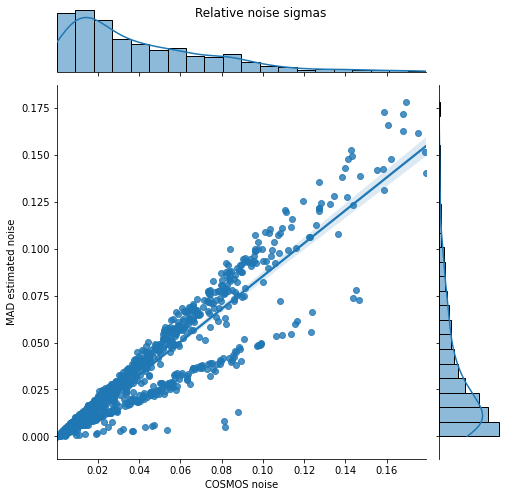

SpearmanrResult(correlation=0.9399486639486639, pvalue=0.0)

In [7]:
import seaborn as sns
import scipy

g=sns.jointplot(x='COSMOS noise', y='MAD estimated noise', data=df_sigmas,
                  kind="reg",height=7)
g.fig.suptitle('Relative noise sigmas')
plt.show()
scipy.stats.spearmanr(df_sigmas[['COSMOS noise','MAD estimated noise']])

In [8]:
import statsmodels.api as sm
endog = df_sigmas['MAD estimated noise']
exog = sm.add_constant(df_sigmas['COSMOS noise'])
mod = sm.OLS(endog, exog)
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     MAD estimated noise   R-squared:                       0.871
Model:                             OLS   Adj. R-squared:                  0.871
Method:                  Least Squares   F-statistic:                     6735.
Date:                 Sun, 09 May 2021   Prob (F-statistic):               0.00
Time:                         14:02:23   Log-Likelihood:                 3025.1
No. Observations:                 1000   AIC:                            -6046.
Df Residuals:                      998   BIC:                            -6036.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0022      0.001     -3.815      0.000      -0.003      -0.001
COSMOS noise     0.8747      0.011     82.070      0.000       0.854       0.896
==============================================================================
Omnibus:                      318.229   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1194.378
Skew:                          -1.491   Prob(JB):                    4.41e-260
Kurtosis:                       7.446   Cond. No.                         28.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Well, If we study dependence between COSMOS noise and MAD noise (in relative units) for 1000 randomly chosen galaxies we see the linear dependence.

Linear coefficient is almost 1 and bias is almost insignificant. 
The problem is almost the scatterplot has three branches which is strange. The first two images refer to noise extraction in 4 8x8 border regions. If we expand them to 20x20 the second branch become even more clear. It can not be related to accounting galaxy light in MAD beacause COSMOS overestimates noise, not MAD.


I could use COSMOS for chi_sq Sersic fitting. The one from which I get angle and ellipticity for radial profile. But given this strange branchy behaviour and COSMOS' noise overestimation I will just use MAD for everything

The good point of COSMOS noise is that it is either close to the correct one or gives a slight overestimation.

## Sersic ellipticity q and angle phi

In [30]:
ellipt=np.zeros((1000,2))
angle=np.zeros((1000,2))
for i in tqdm(range(1000)):
    index=int(np.random.choice(np.linspace(0,cat.nobjects-1,cat.nobjects)))
    
    #Cosmos noise
    COSMOS_q=cat.getParametricRecord(index)['sersicfit'][3]
    COSMOS_phi=cat.getParametricRecord(index)['sersicfit'][-1]
    
    #estimated noise
    gal,noise=get_galaxy(index)
    original_image=gal.drawImage(use_true_center=True, method='auto').array
    Sersic_fit,_=Image_Fits_Stats.fit_image(original_image)
    q,x0,y0,phi=Sersic_fit[-4:]
    
    ellipt[i]=[COSMOS_q,q]
    angle[i]=[COSMOS_phi,phi]

100%|██████████| 1000/1000 [06:02<00:00,  2.76it/s]


In [31]:
#df_ellipt=pd.DataFrame(ellipt,columns=['COSMOS q','Estimated q'])
#df_phi=pd.DataFrame(angle,columns=['COSMOS phi','Estimated phi'])
#df_ellipt.to_csv('Ellipt.csv')
#df_phi.to_csv('Angle.csv')

In [69]:
df_ellipt=pd.read_csv('Ellipt.csv',index_col=0)
df_phi=pd.read_csv('Angle.csv',index_col=0)

## Ellipticities

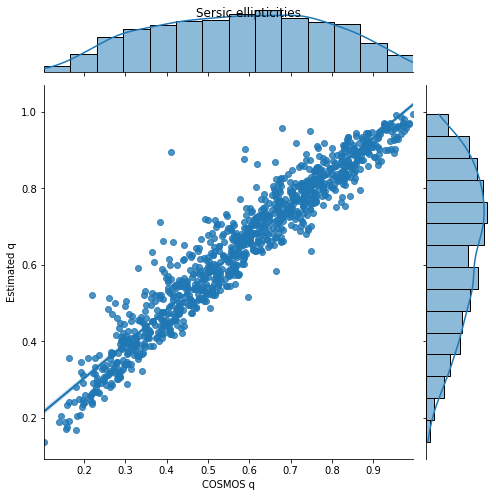

SpearmanrResult(correlation=0.9609702900335771, pvalue=0.0)

In [33]:
g=sns.jointplot(x='COSMOS q', y='Estimated q', data=df_ellipt,
                  kind="reg",height=7)
g.fig.suptitle('Sersic ellipticities')
plt.show()
scipy.stats.spearmanr(df_ellipt[['COSMOS q','Estimated q']])

In [38]:
endog = df_ellipt['Estimated q']
exog = sm.add_constant(df_ellipt['COSMOS q'])
mod = sm.OLS(endog, exog)
results = mod.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.921     
Dependent Variable: Estimated q      AIC:                -2981.9685
Date:               2021-05-09 14:27 BIC:                -2972.1530
No. Observations:   1000             Log-Likelihood:     1493.0    
Df Model:           1                F-statistic:        1.157e+04 
Df Residuals:       998              Prob (F-statistic): 0.00      
R-squared:          0.921            Scale:              0.0029621 
---------------------------------------------------------------------
              Coef.    Std.Err.      t       P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const         0.1231     0.0051    24.0013   0.0000   0.1131   0.1332
COSMOS q      0.8988     0.0084   107.5782   0.0000   0.8824   0.9152
-------------------------------------------------------------------
Omnibus:              254.449       Durbin-Watson:          2.067  
Prob(Omnibus):        0.000         Jarque-Bera (JB):       981.181
Skew:                 1.166         Prob(JB):               0.000  
Kurtosis:             7.255         Condition No.:          7      
===================================================================

"""

## Angles

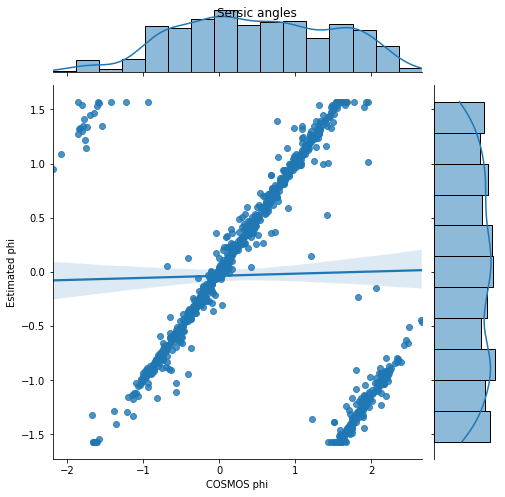

SpearmanrResult(correlation=0.05958070265126032, pvalue=0.059642915948572316)

In [42]:
g=sns.jointplot(x='COSMOS phi', y='Estimated phi', data=df_phi,
                  kind="reg",height=7)
g.fig.suptitle('Sersic angles')
plt.show()
scipy.stats.spearmanr(df_phi[['COSMOS phi','Estimated phi']])

Transform outlying COSMOS angles to [-pi/2,pi/2] 

In [70]:
#df_phi.loc[df_phi['COSMOS phi']<-np.pi/2,'COSMOS phi']=df_phi[df_phi['COSMOS phi']<-np.pi/2]['COSMOS phi']+np.pi
#df_phi.loc[df_phi['COSMOS phi']>np.pi/2,'COSMOS phi']=df_phi[df_phi['COSMOS phi']>np.pi/2]['COSMOS phi']-np.pi

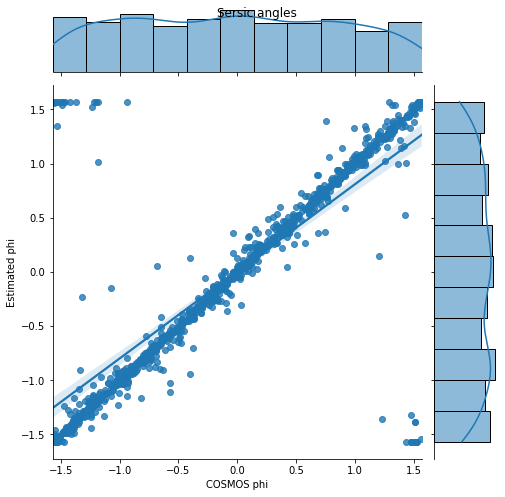

SpearmanrResult(correlation=0.8051231435096919, pvalue=1.2118563792766297e-228)

In [72]:
g=sns.jointplot(x='COSMOS phi', y='Estimated phi', data=df_phi,
                  kind="reg",height=7)
g.fig.suptitle('Sersic angles')
plt.show()
scipy.stats.spearmanr(df_phi[['COSMOS phi','Estimated phi']])

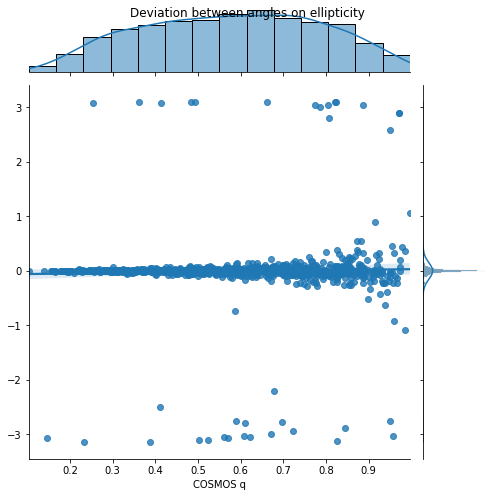

In [74]:
g=sns.jointplot(x=df_ellipt['COSMOS q'], y=df_phi['COSMOS phi']-df_phi['Estimated phi'],
                  kind="reg",height=7)
g.fig.suptitle('Deviation between angles on ellipticity')
plt.show()

Mask out values around np.pi/2

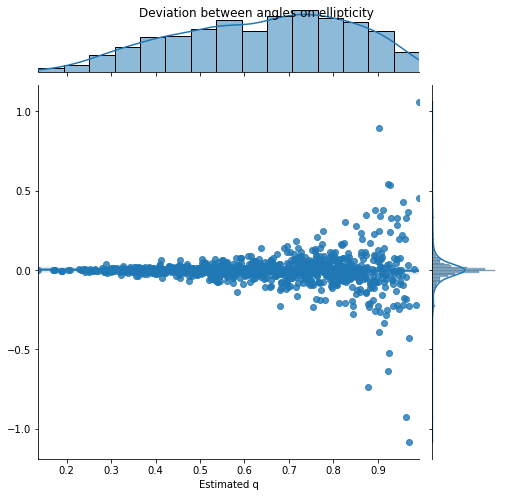

In [76]:
angle_deviations=df_phi['COSMOS phi']-df_phi['Estimated phi']
Mask=np.abs(angle_deviations)<2
g=sns.jointplot(x=df_ellipt[Mask]['Estimated q'], y=angle_deviations[Mask],
                  kind="reg",height=7)
g.fig.suptitle('Deviation between angles on ellipticity')
plt.show()

In [43]:
endog = df_phi['Estimated phi']
exog = sm.add_constant(df_phi['COSMOS phi'])
mod = sm.OLS(endog, exog)
results = mod.fit()
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     -0.001   
Dependent Variable: Estimated phi    AIC:                2643.6756
Date:               2021-05-09 14:27 BIC:                2653.4912
No. Observations:   1000             Log-Likelihood:     -1319.8  
Df Model:           1                F-statistic:        0.4597   
Df Residuals:       998              Prob (F-statistic): 0.498    
R-squared:          0.000            Scale:              0.82185  
-------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
-------------------------------------------------------------------
const           -0.0369    0.0320  -1.1516  0.2498  -0.0997  0.0260
COSMOS phi       0.0194    0.0287   0.6780  0.4979  -0.0368  0.0757
------------------------------------------------------------------
Omnibus:              455.866       Durbin-Watson:          2.049 
Prob(Omnibus):        0.000         Jarque-Bera (JB):       53.503
Skew:                 0.007         Prob(JB):               0.000 
Kurtosis:             1.867         Condition No.:          2     
==================================================================

"""

In [28]:
Sersic_q

0.2104390582694584

In [29]:
Sersic_phi

0.8986078922610321

# Rotation

In [9]:
from coord import radians,degrees

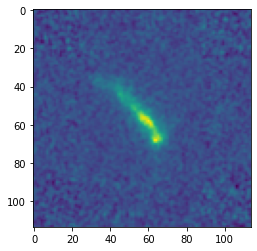

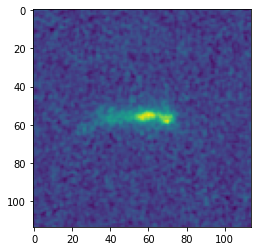

In [10]:
index=16
gal,noise=get_galaxy(index)

#Original image
original_image=gal.drawImage(use_true_center=True, method='auto').array
plt.imshow(original_image)
plt.show()

#Rotation
Sersic_fit,_=Image_Fits_Stats.fit_image(original_image)
q,x0,y0,phi=Sersic_fit[-4:]
# It turns anticlockwise, therefore we need to pass -angle
rot_phi=galsim.Angle(-phi*radians)
rotated_image=gal.rotate(rot_phi).drawImage(use_true_center=True, method='auto').array
plt.imshow(rotated_image)
plt.show()

# Fitting

In [8]:
df_sigmas['MAD estimated noise'].median()

0.023735173005862434

In [15]:
gal,noise=get_galaxy(index)
original_image=gal.drawImage(use_true_center=True, method='auto').array
estimated_noise=estimate_sigma(original_image,20)

Gaussian errors 0.002689111565523879


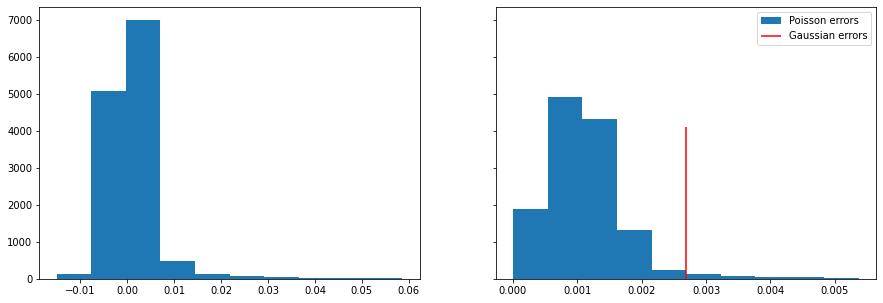

In [42]:
Poisson_errors=np.sqrt(np.abs(original_image/2028))
Gaussian_errors=np.full(original_image.shape,estimated_noise)
f, ax = plt.subplots(1, 2, figsize=(15,5),sharey=True)
ax[0].hist(original_image.flatten())
ax[1].hist(Poisson_errors.flatten(),label='Poisson errors')
ax[1].vlines(Gaussian_errors[0,0],0,4096,color='r',label='Gaussian errors')
print('Gaussian errors',Gaussian_errors[0,0])
plt.legend()
plt.show()

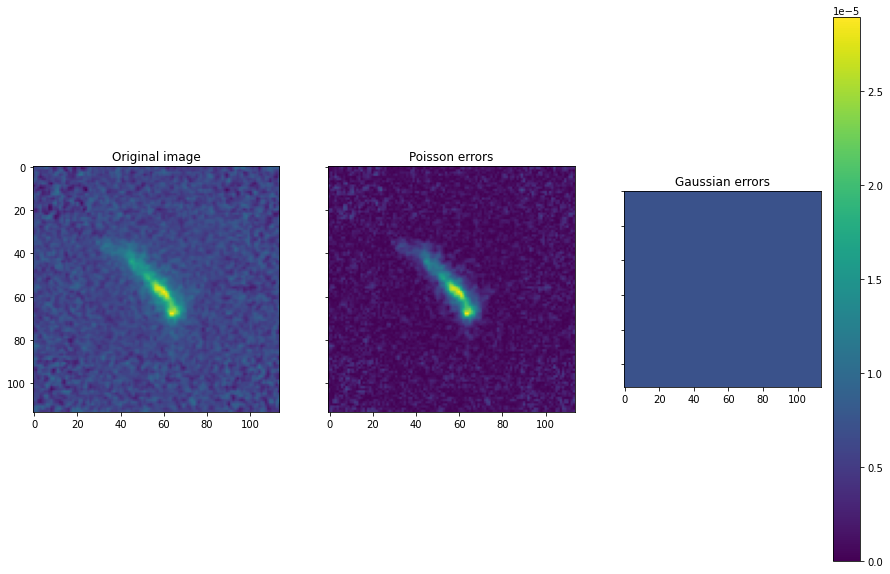

In [53]:
f, ax = plt.subplots(1, 3, figsize=(15,10),sharey=True)
ax[0].imshow(original_image)
ax[0].set_title("Original image")
im=ax[1].imshow(Poisson_errors**2,vmax=(Poisson_errors**2).max(),vmin=0)
ax[1].set_title("Poisson errors")
ax[2].imshow(Gaussian_errors**2,vmax=(Poisson_errors**2).max(),vmin=0)
ax[2].set_title("Gaussian errors")
plt.colorbar(im,ax=ax[2])
plt.show()

In [147]:
def plot_3d(image,zlim=None):
        
        X = np.arange(0, image.shape[1], 1)
        Y = np.arange(0, image.shape[0], 1)
        X, Y = np.meshgrid(X, Y)
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.plot_surface(X, Y, image, cmap=cm.coolwarm,linewidth=0, antialiased=False)
        if zlim:
            ax.set_zlim(0,zlim)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()

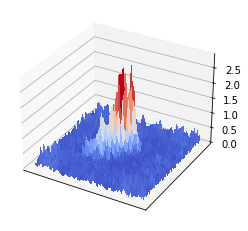

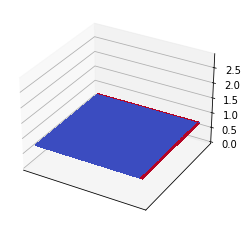

In [54]:
#3d Poisson and Gaussian errors
plot_3d(Poisson_errors**2,(Poisson_errors**2).max())
plot_3d(Gaussian_errors**2,(Poisson_errors**2).max())

## Errors comparison

In [243]:

def get_rotated_gal(index):
    gal,noise=get_galaxy(index)

    #Original image
    original_image=gal.drawImage(use_true_center=True, method='auto').array
    #Rotation
    Sersic_fit,_=Image_Fits_Stats.fit_image(original_image)
    q,x0,y0,phi=Sersic_fit[-4:]
    # It turns anticlockwise, therefore we need to pass -angle
    rot_phi=galsim.Angle(-phi*radians)
    rotated_image=gal.rotate(rot_phi).drawImage(use_true_center=True, method='auto').array
    estimated_noise_rot=estimate_sigma(rotated_image,20)
    return rotated_image,estimated_noise_rot,x0,y0,q


def compare_errors(index):
    
    rotated_image,estimated_noise_rot,x0,y0,q=get_rotated_gal(index)
    

    Radial_profile=Image_Fits_Stats.Radial_profile(rotated_image,q,x0,y0,0)
    
    significance_radius=np.where(Radial_profile>3*estimated_noise_rot)[0].max()
    print('Significance radius',significance_radius)

    #Getting border of galaxy from radial profile
    Radial_profile=Radial_profile-Radial_profile[-1]
    Radial_profile/=Radial_profile.max()
    R_cut=np.where((Radial_profile<0.01))[0][0]
    
    Poisson_errors=np.sqrt(np.abs(rotated_image[round(x0)]/2028))
    Gaussian_errors=np.full(rotated_image.shape[1],estimated_noise_rot)
    
    
    Noise_pixels=np.where(Poisson_errors<Gaussian_errors)[0]-round(y0)
    Right_cut=Noise_pixels[Noise_pixels>0]
    Left_cut=(-Noise_pixels[Noise_pixels<0])
    if len(Right_cut)!=0:
        Right_cut=Right_cut.min()
    else:
        Right_cut=rotated_image.shape[1]-round(y0)
    if len(Left_cut)!=0:
        Left_cut=Left_cut.min()
    else:
        Left_cut=round(y0)
    R_thr=np.maximum(Right_cut,Left_cut)

    plt.figure(figsize=(15,10))
    plt.title('Chi squared error 'r'$\sigma^2$')
    plt.plot(Poisson_errors**2,label=r'Poisson $\sigma^2$')
    plt.hlines(Gaussian_errors**2,0,rotated_image.shape[1],label=r'Gaussian $\sigma^2$',color='r')
    
    vlines_height=(Poisson_errors**2).max()/5
    
    plt.vlines(y0+R_cut,0,vlines_height,color='k',label='R_cut Radial profile')
    plt.vlines(y0-R_cut,0,vlines_height,color='k')
    
    plt.vlines(y0+R_thr,0,vlines_height,color='C1',label='R_thr errors')
    plt.vlines(y0-R_thr,0,vlines_height,color='C1')
    
    plt.legend()
    plt.show()
    
    
    return rotated_image,R_cut,R_thr,round(x0),round(y0)

def overview_cut_methods(index):
    rotated_image,R_cut,R_thr,x0,y0=compare_errors(index)
    f, ax = plt.subplots(1, 3, figsize=(15,10))
    ax[0].imshow(rotated_image)
    ax[0].set_title("Original image")
    R_cut=np.minimum(np.min(rotated_image.shape)//2,R_cut)
    ax[1].imshow(rotated_image[x0-R_cut:x0+R_cut,y0-R_cut:y0+R_cut])
    ax[1].set_title('Radial cut %d' % R_cut)
    R_thr=np.minimum(np.min(rotated_image.shape)//2,R_thr)
    ax[2].imshow(rotated_image[x0-R_thr:x0+R_thr,y0-R_thr:y0+R_thr])
    ax[2].set_title('Error threshold cut %d' % R_thr)
    plt.show()

Significance radius 107


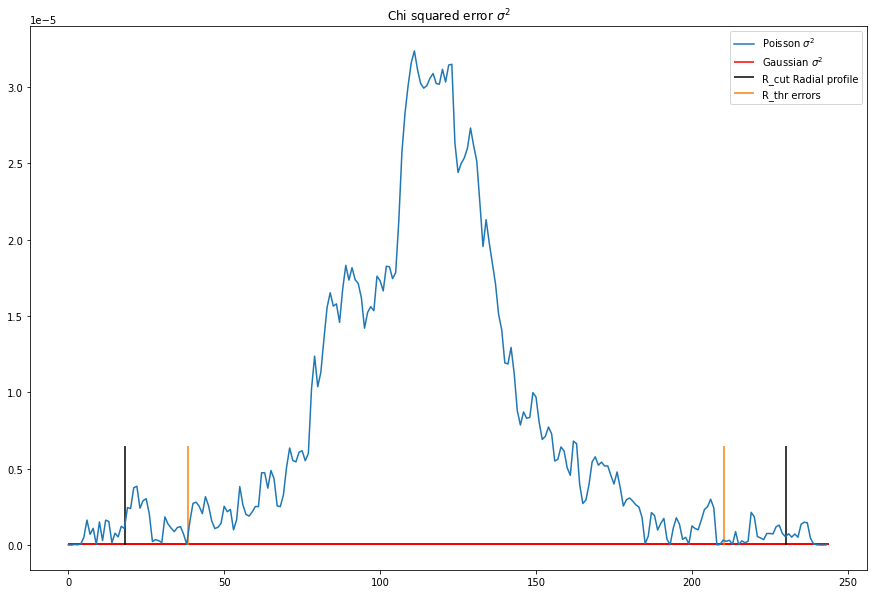

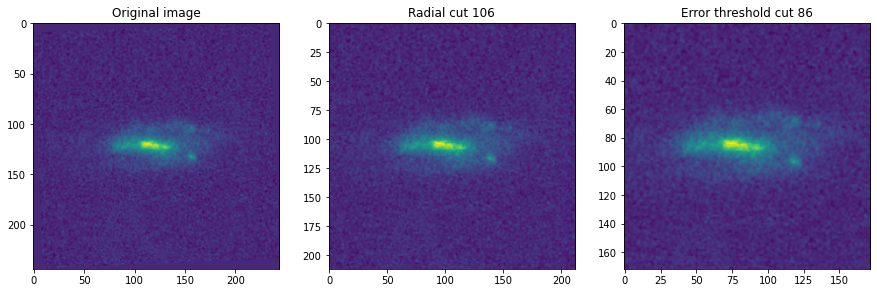

In [223]:
overview_cut_methods(0)

Error thr is almost perfect. Still has some overestimation

Significance radius 25


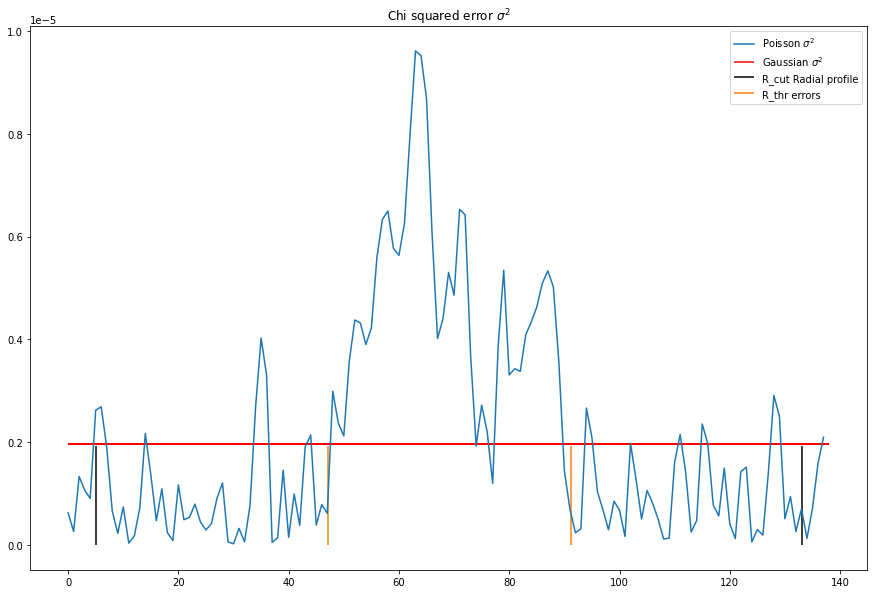

66 69


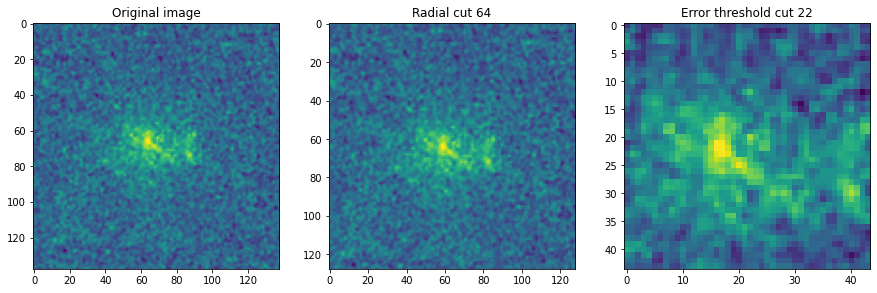

In [228]:
overview_cut_methods(6)

Almost perfect once again. Underestimation this time

Significance radius 38


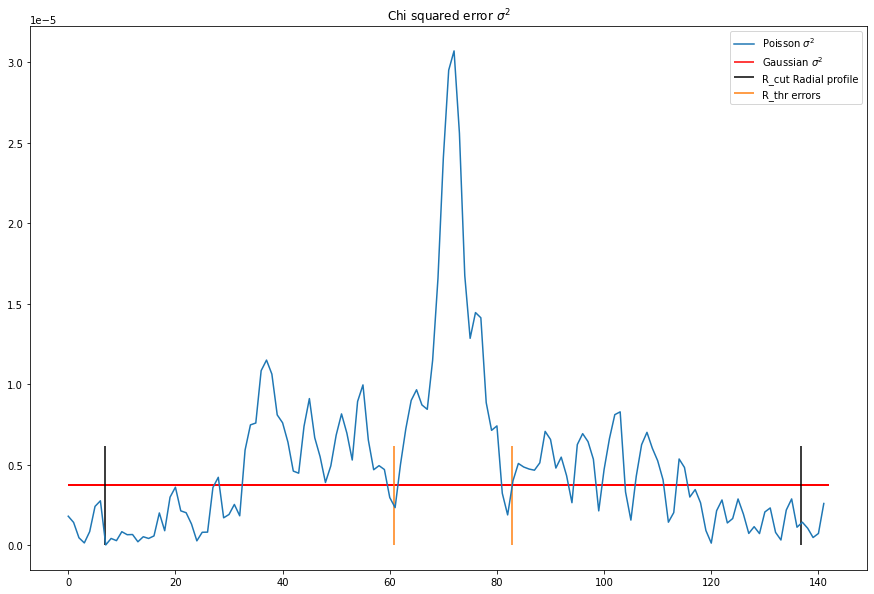

71 72


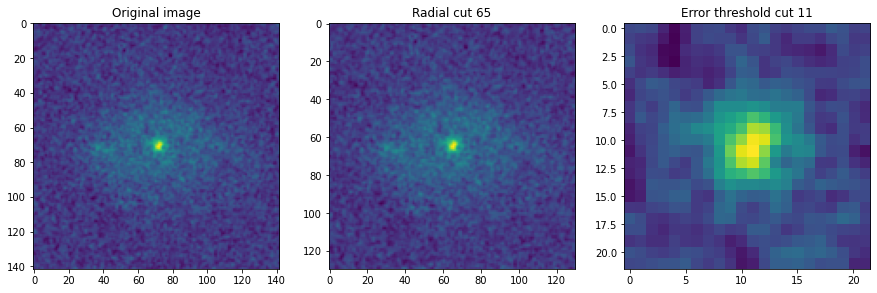

In [229]:
overview_cut_methods(10)

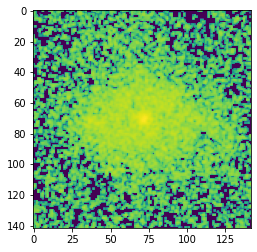

In [207]:
rotated_image,_,_,_,_=get_rotated_gal(10)
rotated_image[rotated_image<0]=np.abs(rotated_image).min()
plt.imshow(rotated_image,norm=LogNorm(rotated_image.min(),rotated_image.max()))

It is very questionable whether there is a light from galaxy disk or not. All the light is behind the noise. If there is no light then the R_thr is perfect. I guess I can just smooth the images a bit before determining the R_cut so I would not face problems with noise outliers. 

Significance radius 94


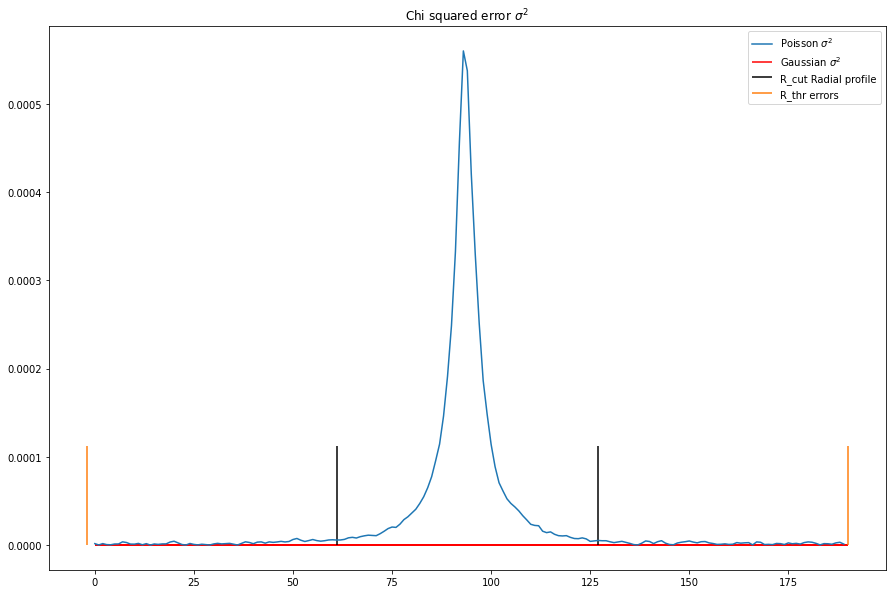

<ipython-input-243-736a4b29fae7>:76: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax[2].imshow(rotated_image[x0-R_thr:x0+R_thr,y0-R_thr:y0+R_thr])


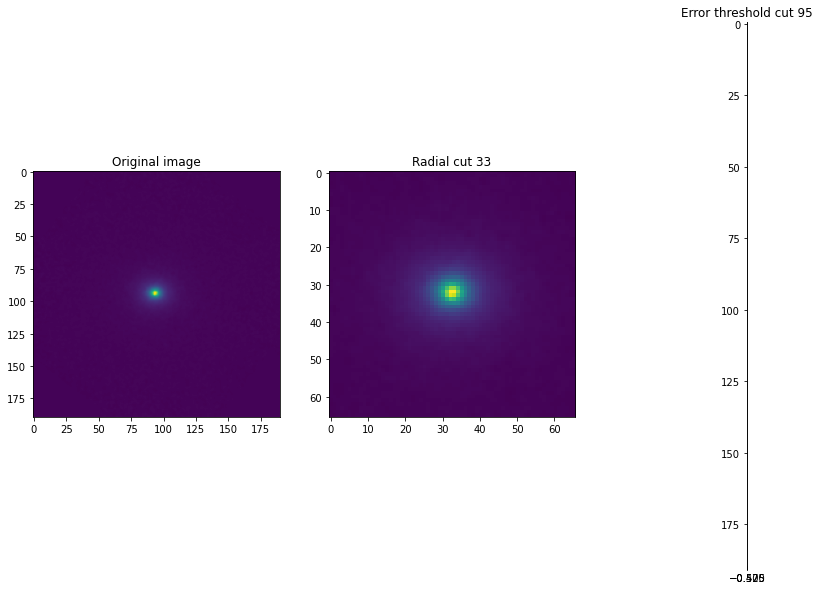

In [244]:
overview_cut_methods(12)

Significance radius 80


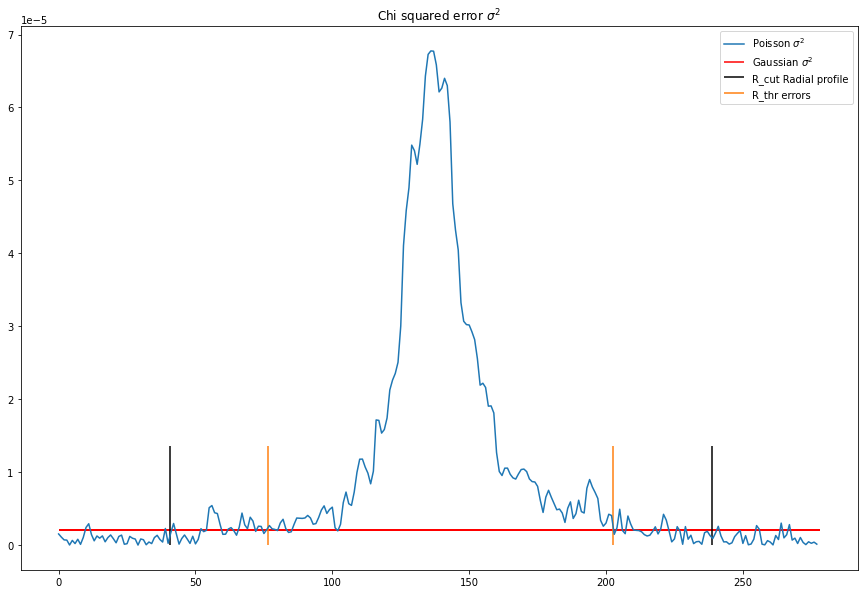

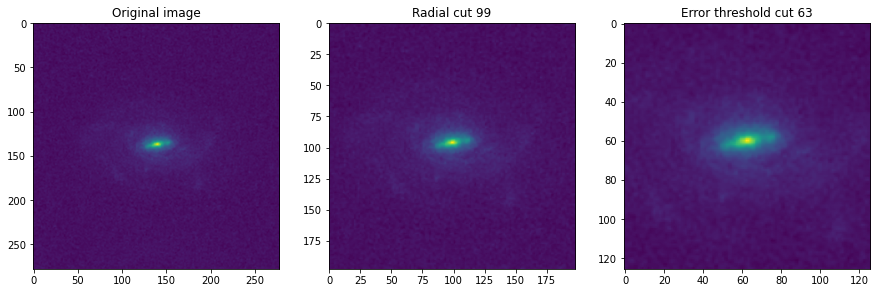

In [245]:
overview_cut_methods(15)

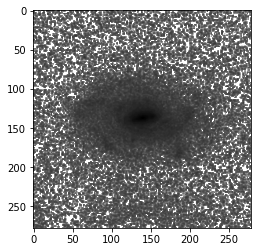

In [248]:
rotated_image,_,_,_,_=get_rotated_gal(15)
rotated_image[rotated_image<0]=np.abs(rotated_image).min()
plt.imshow(rotated_image,norm=LogNorm(rotated_image.min(),rotated_image.max()),cmap='gray_r')

# Noise extrcation region

In [12]:
Labels=pd.read_csv('Labels_0_50932_old.csv',index_col=0)
Labels.head()

COSMOS_index  COSMOS_Bulge_HLR  COSMOS_Bulge_I  COSMOS_Bulge_n  \
0             0         13.600641        0.004279             4.0   
1             1          0.201440        0.258925             4.0   
2             2          0.510588        0.528859             4.0   
3             3          2.310266        0.000000             4.0   
4             4          2.254391        0.022633             4.0   

   COSMOS_Bulge_phi  COSMOS_Bulge_q  COSMOS_Bulge_x0  COSMOS_Bulge_y0  \
0          1.698688        0.050000       247.249777       251.840007   
1          2.009977        0.614526       177.920633       178.784481   
2         -3.063154        0.050000       107.890388       108.379722   
3          0.004540        0.050000       173.005949       174.406523   
4          2.249803        0.620285       102.961122       102.482383   

   COSMOS_Disk_HLR  COSMOS_Disk_I  ...  Sersic_y0_err   mag_auto     max_I  \
0        14.759418       0.012038  ...       0.140400  21.040642  0.570709   
1        15.099626       0.011899  ...       0.123807  21.782894  0.154042   
2         7.153612       0.047064  ...       0.084147  22.861856  0.133911   
3        15.952558       0.008017  ...       0.131422  22.229794  0.080922   
4         5.186225       0.042089  ...       0.071068  23.283966  0.126981   

      min_I   zphot        SNR  SNR_COSMOS  COSMOS_R_cut  NonUniformity  R_cut  
0 -0.037081  0.1950  53.763315  223.814253     44.901452      22.218840     27  
1 -0.016080  0.7552  38.302530   57.903729     36.048607      12.510214     28  
2 -0.011602  0.9616  46.864650   34.559685     18.143305      25.409052     24  
3 -0.015357  0.9266  20.043728   31.663673     29.817058       9.556059     31  
4 -0.010049  0.6719  55.347211   45.456929     14.602186      33.596505     19  

[5 rows x 54 columns]

In [24]:
Labels.columns

Index(['COSMOS_index', 'COSMOS_Bulge_HLR', 'COSMOS_Bulge_I', 'COSMOS_Bulge_n',
       'COSMOS_Bulge_phi', 'COSMOS_Bulge_q', 'COSMOS_Bulge_x0',
       'COSMOS_Bulge_y0', 'COSMOS_Disk_HLR', 'COSMOS_Disk_I', 'COSMOS_Disk_n',
       'COSMOS_Disk_phi', 'COSMOS_Disk_q', 'COSMOS_Disk_x0', 'COSMOS_Disk_y0',
       'COSMOS_Sersic_HLR', 'COSMOS_Sersic_I', 'COSMOS_Sersic_n',
       'COSMOS_Sersic_phi', 'COSMOS_Sersic_q', 'COSMOS_Sersic_x0',
       'COSMOS_Sersic_y0', 'COSMOS_noise', 'COSMOS_use_bulgefit', 'IDENT',
       'Noise_mean', 'Noise_std', 'Original_R_cut', 'Original_x_size',
       'Original_y_size', 'Sersic_HLR', 'Sersic_HLR_err', 'Sersic_I',
       'Sersic_I_err', 'Sersic_n', 'Sersic_n_err', 'Sersic_phi',
       'Sersic_phi_err', 'Sersic_q', 'Sersic_q_err', 'Sersic_r_chi_sq',
       'Sersic_x0', 'Sersic_x0_err', 'Sersic_y0', 'Sersic_y0_err', 'mag_auto',
       'max_I', 'min_I', 'zphot', 'SNR', 'SNR_COSMOS', 'COSMOS_R_cut',
       'NonUniformity', 'R_cut'],
      dtype='object')

In [15]:
Original_labels=Labels[['Original_R_cut', 'Original_x_size','Original_y_size']]

<ipython-input-20-f30958104052>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Original_labels['Bkg_x_size']=Original_labels['Original_x_size']/2-Original_labels['Original_R_cut']
<ipython-input-20-f30958104052>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Original_labels['Bkg_y_size']=Original_labels['Original_y_size']/2-Original_labels['Original_R_cut']


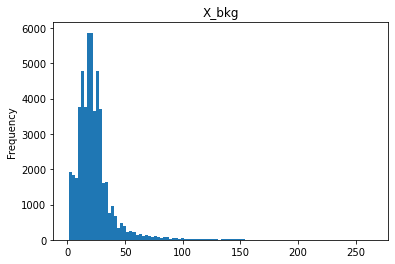

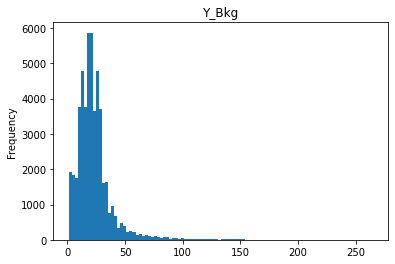

In [20]:
Original_labels['Bkg_x_size']=Original_labels['Original_x_size']/2-Original_labels['Original_R_cut']
Original_labels['Bkg_y_size']=Original_labels['Original_y_size']/2-Original_labels['Original_R_cut']
Original_labels['Bkg_x_size'].plot.hist(bins=100)
plt.title('X_bkg')
plt.show()
Original_labels['Bkg_y_size'].plot.hist(bins=100)
plt.title('Y_Bkg')
plt.show()



In [23]:
Original_labels['Bkg_y_size'].min()

1.0

In [1]:
Original_labels['Bkg_y_size'].median()

NameError: name 'Original_labels' is not defined

0


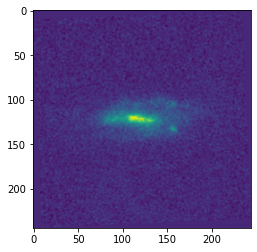

1


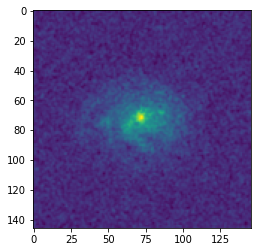

2


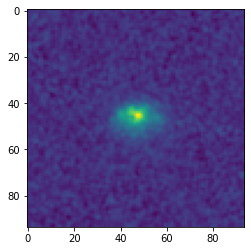

3


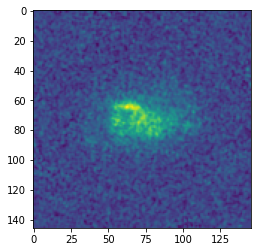

4


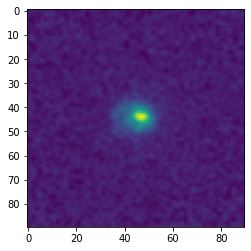

5


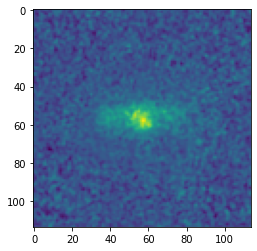

6


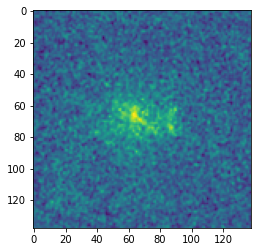

7


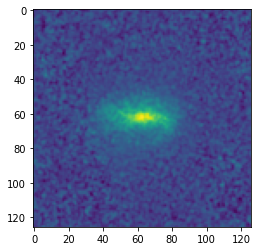

8


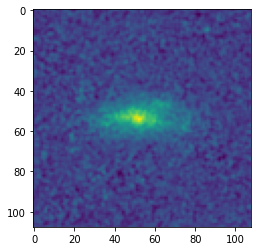

9


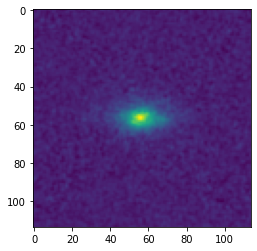

10


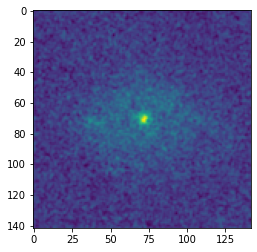

11


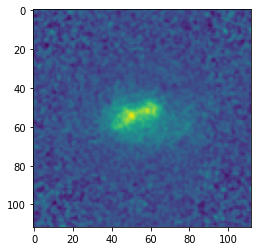

12


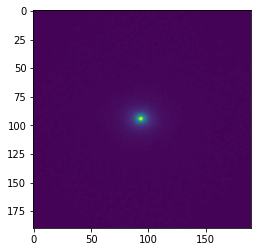

13


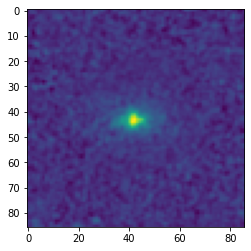

14


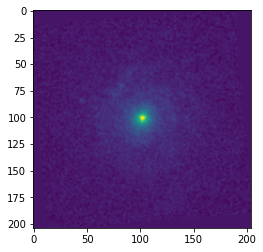

15


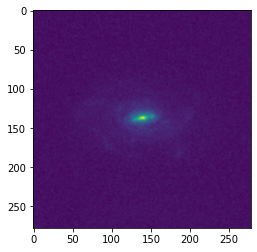

16


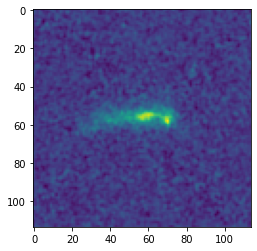

17


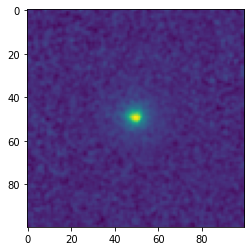

18


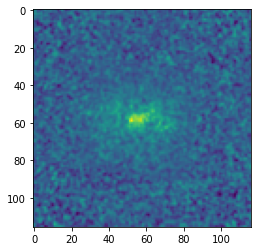

19


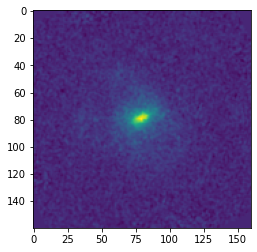

In [185]:
for i in range(20):
    print(i)
    rotated_image,_,_,_,_=get_rotated_gal(i)
    plt.imshow(rotated_image)
    plt.show()

### Radial cut

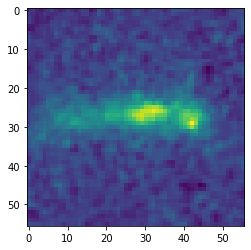

In [164]:
R_cut

28

In [165]:
R_thr

26.436913095541563

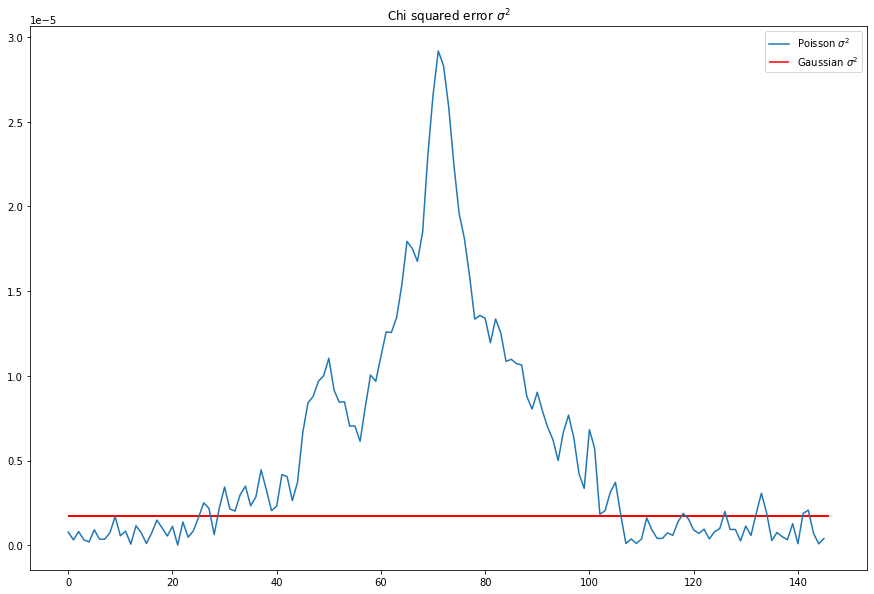

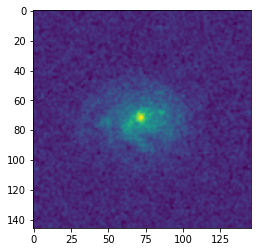

In [107]:
rotated_image=compare_errors(1)
plt.imshow(rotated_image)
plt.show()

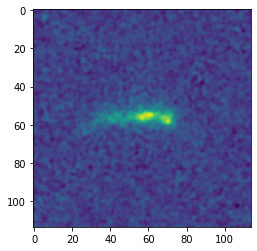

In [64]:
plt.imshow(rotated_image)

In [38]:
#Exposure time for COSMOS is 2028 (https://iopscience.iop.org/article/10.1086/520086/pdf)
def fit_image(image,profile_type='Sersic',noise_std=None,exposure_time=None):
    x = np.linspace(0, image.shape[1], image.shape[1])
    y = np.linspace(0, image.shape[0], image.shape[0])
    X, Y = np.meshgrid(x, y)
    # We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
    xdata = np.vstack((X.ravel(), Y.ravel()))

    if profile_type=='Sersic':
        func=Sersic_profile
        n_initial=1
        k=2*n_initial-0.324
        initial_guess=np.array([image.max()*np.exp(-k),5,n_initial,0.64,
                            image.shape[1]/2,image.shape[0]/2,0])
        lower_bounds=np.array([image.max()*1e-5,0,0.5,0.01,0,0,-np.pi/2])
        upper_bounds=np.array([image.max(),np.min(image.shape)/2,6,1,
                           image.shape[1],image.shape[0],np.pi/2])

    elif profile_type=='Chameleon':
        func=Chameleon_profile
        initial_guess=np.array([image.max(),5,0.5,0.5,image.shape[1]/2,image.shape[0]/2,0])
        lower_bounds=np.array([image.max()*1e-5,0,0,0.01,0,0,-np.pi/2])
        upper_bounds=np.array([np.inf,np.inf,1,1,image.shape[1],image.shape[0],np.pi/2])

    elif profile_type=='Chameleon_Sersic':
        func=Chameleon_Sersic
        n_initial=1
        k=2*n_initial-0.324
        initial_guess=np.array([image.max()*20,2,0.1,0.64,0,
                             image.max()*np.exp(-k),5,n_initial,0.64,0,
                             image.shape[1]/2,image.shape[0]/2])
        lower_bounds=np.array([image.max()*1e-5,0,0,0.01,-np.pi/2,
                           0,0,0.5,0.01,-np.pi/2,
                           0,0])
        upper_bounds=np.array([np.inf,np.inf,1,1,np.pi/2,
                           image.max(),np.min(image.shape)/2,6,1,np.pi/2,
                           image.shape[1],image.shape[0]])
    elif profile_type=='Double_Sersic':
        func=Double_Sersic
        n_initial=np.array([4,1])
        k=2*n_initial-0.324
        Iratio_init=np.exp(-k[0]+k[1])
        initial_guess=np.array([image.max()*np.exp(-k[0]),2,n_initial[0],0.64,0,
                             Iratio_init,5,n_initial[1],0.64,0,
                             image.shape[1]/2,image.shape[0]/2])
        lower_bounds=np.array([image.max()*1e-5,0,0.5,0.01,-np.pi/2,
                           0,0,0.5,0.01,-np.pi/2,
                           0,0])
        upper_bounds=np.array([image.max(),np.min(image.shape)/2,6,1,np.pi/2,
                           1,np.min(image.shape)/2,6,1,np.pi/2,
                           image.shape[1],image.shape[0]])

    else:
        print('Wrong profile type')
        return False

    #assume that exposure time is 1
    Poisson_errors=np.sqrt(np.abs(image))
    #0.0244 is a median MAD extracted relative gaussian noise sigma of the COSMOS dataset
    #See "Preformance test" notebook
    Gaussian_errors=np.sqrt(image.max()*0.0244)
    if exposure_time:
        Poisson_errors/=np.sqrt(exposure_time)
    if noise_std:
        Gaussian_errors=noise_std

    sigma=np.sqrt(np.power(Poisson_errors,2)+np.power(Gaussian_errors,2))

    popt, pcov = curve_fit(f=func, xdata=xdata,
                               ydata=image.ravel(),
                               p0=initial_guess,
                               sigma=sigma.ravel(),
                               bounds=(lower_bounds,upper_bounds))
    return popt,np.sqrt(np.diag(pcov))